In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Load card data

In [2]:
# note that there are no nulls in test/train except for ONE ROW in test! (first_active_month)

In [3]:
# Load just the card ids and target
dtypes = {
  'card_id':            'str',     # 201917 unique vals
  'target':             'float32', # -33.22 thru ~18
  'first_active_month': 'str',     # 2011-10 thru 2018-02
  'feature_1':          'uint8',   # 1 thru 5
  'feature_2':          'uint8',   # 1 thru 3
  'feature_3':          'uint8',   # 0 and 1
}
train = pd.read_csv('../input/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['target']
test = pd.read_csv('../input/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)

# Add target col to test
test['target'] = np.nan

# Merge test and train
cards = pd.concat([train, test])

As a quick sanity check, let's make sure there aren't any `card_id`s which are in both test and train:

In [4]:
print('Num unique in train:  ', test['card_id'].nunique())
print('Num unique in test:   ', train['card_id'].nunique())
print('The sum:              ', test['card_id'].nunique()+train['card_id'].nunique())
print('Num unique in merged: ', cards['card_id'].nunique())

Num unique in train:   123623
Num unique in test:    201917
The sum:               325540
Num unique in merged:  325540


OK good, there aren't.  Now we can delete the original dataframes.

In [5]:
del train, test
gc.collect()

22

Let's take a look at the cards data.

In [6]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
145440,2017-04,C_ID_e6ce051a88,2,1,0,0.524850
75145,2016-03,C_ID_c89a3d7314,3,3,1,1.230188
68932,2017-10,C_ID_c4391f4e8e,3,1,1,-0.785787
178609,2016-02,C_ID_d708ebce45,4,2,0,-2.955879
124789,2017-01,C_ID_2e45ddd95a,4,1,0,0.406096
3056,2014-12,C_ID_8fb4665bcc,3,1,1,1.105307
172981,2016-09,C_ID_32b268b402,5,2,1,-6.138566
20167,2017-07,C_ID_7b50ed39a3,3,2,1,NaN
162556,2016-05,C_ID_2384e9efc8,3,2,1,0.537485
127095,2016-06,C_ID_9d4621cbea,3,2,1,0.865951


The `card_id`s always start with `C_ID_`.  That's kind of a waste of space...  All the `card_id`s are the same length:

In [7]:
cards['card_id'].apply(len).unique()

array([15])

If we cut off the prefix, the remaining strings appear to be all hexidecimal (represented by values 0-9 and a-f):

In [8]:
cards['card_id'].str.slice(5, 15).sample(10)

28850     c3368a5c25
14702     0dc239ec2f
188398    96ee77b508
33047     7c3ce43f37
74278     01ea37f8f5
98083     74005119cb
70994     bf7cb0d5be
41466     c4d6215485
149340    c4317bc6b6
117346    e53872b420
Name: card_id, dtype: object

We can check that every single entry is indeed a hexideximal:

In [9]:
(cards['card_id']
 .str.slice(5, 15)
 .apply(lambda x: all(e in '0123456789abcdef' for e in x))
 .all())

True

To save space, we could convert the `card_id`s to integers like this:

In [10]:
#cards['card_id'] = cards['card_id'].apply(lambda x: int(x, 16)).astype('uint64')

We could save *more* space by using `uint32`s.  There are only 201,917 unique `card_id`s in `train.csv` and 123,623 in `test.csv`, which can easily be represented by a `uint32` (which stores values up to ~4B).  BUT, there are 5 bytes worth of hex info in the card ids, and the values span the full 5-byte range, so we'd have to use a 64-bit integer to represent them (instead of a 32-bit int, which is only 4 bytes).  To use a 32-bit integer, we'll create a map between the card_id and a unique integer which identifies it, and then map the string values to integer values.  (we need to create a map so that we can map the values in the transactions data in the exact same way)

In [11]:
# Create a map from card_id to unique int
card_id_map = dict(zip(
    cards['card_id'].values,
    cards['card_id'].astype('category').cat.codes.values
))

# Map the values
cards['card_id'] = cards['card_id'].map(card_id_map).astype('uint32')

Now our `card_id`s are 32-bit integers:

In [12]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
82302,2017-05,135542,1,1,0,0.000000
6751,2017-03,165913,2,1,0,NaN
6357,2016-05,162033,5,1,1,NaN
194729,2016-03,215055,3,3,1,0.059941
100180,2017-07,160502,3,2,1,NaN
47811,2015-11,108111,2,2,0,2.185499
186200,2017-04,28969,1,1,0,-0.773958
117044,2017-08,189514,1,1,0,0.496853
39703,2017-01,93092,5,1,1,0.097291
201676,2017-04,117585,2,3,0,0.180213


Next, we'll convert the `first_active_month` from a string to a datetime.  Unfortunately, there is one.  Single.  Row.  Where `first_active_month` is NaN.

In [13]:
cards[cards['first_active_month'].isnull()]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
11578,NaN,247334,5,2,1,NaN


But other than that row, all the other `first_active_months` are in `YYYY-MM` format:

In [14]:
def nanlen(x):
    if type(x) is float:
        return 'NaN'
    else:
        return len(x)
    
cards['first_active_month'].apply(nanlen).unique()

array([7, 'NaN'], dtype=object)

So, we can convert `first_active_month` column to datetime format.

In [15]:
# Convert first_active_month to datetime
cards['first_active_month'] = pd.to_datetime(cards['first_active_month'],
                                             utc=True,
                                             format='%Y-%m')

Finally, we'll set the index to be the `card_id`.

In [16]:
# Make card_id the index
cards.set_index('card_id', inplace=True)
cards.sample(10)

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
98524,2017-02-01 00:00:00+00:00,5,1,1,NaN
95689,2017-10-01 00:00:00+00:00,3,2,1,NaN
158067,2017-10-01 00:00:00+00:00,2,3,0,0.069238
67335,2017-02-01 00:00:00+00:00,4,1,0,-0.924701
291464,2017-09-01 00:00:00+00:00,1,1,0,-0.465049
258460,2016-11-01 00:00:00+00:00,5,1,1,NaN
252311,2017-05-01 00:00:00+00:00,2,1,0,1.074494
272778,2017-10-01 00:00:00+00:00,3,1,1,0.640135
149771,2016-11-01 00:00:00+00:00,2,2,0,-2.354010


In [17]:
# TODO: delete cols you don't need (yet) for memory's sake
del cards['first_active_month']
del cards['feature_1']
del cards['feature_2']
del cards['feature_3']
gc.collect()

117

## Load transactions data

In [18]:
# Datatypes of each column
# only NaNs are in category_3, merchant_id, and category_2
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # lots of unique ones here and nans
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Merge new_merchant_transactions and historical_transactions
trans = pd.concat([hist_trans, new_trans])
del hist_trans, new_trans

We also need to convert the `card_id` to an integer as before, convert the `purchase_date` column (which has been loaded as a string) to datetime format, and encode the categorical columns.

In [19]:
# Convert card_id to integer
trans['card_id'] = trans['card_id'].map(card_id_map).astype('uint32')

# Convert purchase_date to datetime
trans['purchase_date'] = trans['purchase_date'].str.slice(0, 19)
trans['purchase_date'] = pd.to_datetime(trans['purchase_date'],
                                        utc=True,
                                        format='%Y-%m-%d %H:%M:%S')

# Encode categorical columns
bool_map = {'Y': 1, 'N': 0}
#three_map = {'A': 0, 'B': 1, 'C': 2, nan?}
conversions = [
    ('authorized_flag', bool_map, 'uint8'),
    ('category_1', bool_map, 'uint8'),
    #('category_3', three_map, 'uint8'),
]
for col, mapper, new_type in conversions:
    trans[col] = trans[col].map(mapper).astype(new_type)
    
# Clean up
gc.collect()

33

## Load merchants data

In [20]:
# Datatypes of each column
# (don't load cols which are in transactions data, just use those vals)
# Nulls: NO nulls except for 13 rows in avg_sales_lag{3,6,12}
dtypes = {
  'merchant_id':                 'str',     # 334633 unique values
  'merchant_group_id':           'uint32',  # 1 thru 112586 (w/ some missing, ~109k uniques)
  'numerical_1':                 'float32', # ~ -0.06 thru ~ 183.8 (only 951 unique vals?)
  'numerical_2':                 'float32', # roughly the same as above
  'most_recent_sales_range':     'str',     # A, B, C, D, or E
  'most_recent_purchases_range': 'str',     # A, B, C, D, or E
  'avg_sales_lag3':              'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'avg_purchases_lag3':          'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'active_months_lag3':          'uint8',   # 1 to 3 
  'avg_sales_lag6':              'float32', # similar to avg_sales_lag3
  'avg_purchases_lag6':          'float32', # similar to avg_purchases_lag3
  'active_months_lag6':          'uint8',   # 1 to 6
  'avg_sales_lag12':             'float32', # similar to avg_sales_lag3
  'avg_purchases_lag12':         'float32', # similar to avg_purchases_lag3
  'active_months_lag12':         'uint8',   # 1 to 12
  'category_4':                  'str',     # Y or N
}

# Load the data
merchants = pd.read_csv('../input/merchants.csv',
                        usecols=dtypes.keys(),
                        dtype=dtypes)

In [21]:
# Inverse transforms
inversions = [
    'avg_sales_lag3',
    'avg_sales_lag6',
    'avg_sales_lag12',
    'avg_purchases_lag3',
    'avg_purchases_lag6',
    'avg_purchases_lag12',
]
for col in inversions:
    merchants[col] = 1.0/merchants[col]

# Encode categorical columns
bool_map = {'Y': 1, 'N': 0}
five_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
conversions = [
    ('category_4', bool_map, 'uint8'),
    ('most_recent_sales_range', five_map, 'uint8'),
    ('most_recent_purchases_range', five_map, 'uint8')
]
for col, mapper, new_type in conversions:
    merchants[col] = merchants[col].map(mapper).astype(new_type)

Merge merchants and transactions data

In [22]:
# Merge transactions with merchants data
gc.collect()
trans = pd.merge(trans, merchants, on='merchant_id')
del merchants
gc.collect()

trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
27833420,1,131992,331,0,0,A,307,M_ID_2a7d0ea7fe,-4,-0.671775,2017-10-19 00:00:00+00:00,1.0,16,19,6724,-0.057471,-0.057471,2,2,1.000000,0.905433,3,1.086957,0.911300,6,1.075269,0.845229,12,0
3917275,1,89333,69,0,0,A,80,M_ID_c03b62d83d,-9,-0.732633,2017-05-26 19:59:17+00:00,1.0,9,37,3290,1.588403,0.011934,0,0,0.980392,0.954221,3,0.980392,0.932829,6,0.943396,0.907175,12,1
18176039,1,100753,161,0,1,B,705,M_ID_477f0399a3,-1,-0.621557,2017-11-29 18:50:53+00:00,3.0,3,33,1145,-0.047556,-0.057471,0,1,1.030928,0.993104,3,1.010101,0.975196,6,1.063830,0.991106,12,1
19185216,1,12316,333,0,1,B,683,M_ID_0d7f899297,-4,-0.739395,2017-10-31 12:12:23+00:00,1.0,9,34,35,2.421255,2.421255,1,0,0.925926,0.925801,3,0.909091,0.939145,6,0.884956,0.918866,12,0
9001702,1,171643,107,0,0,A,307,M_ID_c56247d7e3,-1,-0.701528,2018-01-12 05:56:50+00:00,4.0,4,19,13231,-0.047556,-0.047556,2,2,1.219512,1.066124,3,1.204819,1.045520,6,1.086957,0.976068,12,0
8462068,1,251608,158,0,0,A,278,M_ID_deb43ff012,-6,-0.502622,2017-08-11 00:47:40+00:00,1.0,15,37,35,48.416496,48.059559,0,0,0.909091,0.907844,3,0.847458,0.872846,6,0.819672,0.853430,12,1
26987963,1,90687,214,0,0,A,307,M_ID_554adf3c00,-7,-0.724368,2017-07-20 06:31:54+00:00,1.0,16,19,217,-0.007896,-0.007896,1,1,0.934579,0.875917,3,0.909091,0.830939,6,0.970874,0.834811,12,0
23970145,0,82844,333,0,0,A,705,M_ID_eae2b7753e,-2,-0.710934,2017-12-16 20:02:20+00:00,5.0,21,33,59331,-0.017811,-0.057471,2,2,0.980392,0.995040,3,0.943396,0.971657,6,0.980392,0.998318,12,0
21171740,1,13390,19,0,0,A,278,M_ID_e26ff76fb1,-5,-0.666907,2017-09-28 17:17:58+00:00,1.0,9,37,2898,-0.057471,-0.057471,3,2,0.909091,0.947569,3,0.934579,0.987007,6,0.854701,0.929972,12,0
1261366,1,208414,69,0,1,B,879,M_ID_00a6ca8a8a,-6,-0.679289,2017-08-23 14:25:44+00:00,1.0,9,29,35,-0.047556,-0.057471,4,4,0.144300,0.078708,3,0.118765,0.063069,6,0.116686,0.061653,7,1


## Feature Engineering (for Transactions)

Compute aggregations for each card_id, and compute the mutual information between the new feature and the target.

In [23]:
# Group transactions by card id
trans = trans.groupby('card_id', sort=False)
gc.collect()

197

Now we engineer features for each card ID by applying aggregation functions to each card's transactions data.  Instead of computing each possible aggregation into one huge dataframe (which might not fit in memory), let's do one aggregation at a time, compute the mutual information with the target of that aggregation, and then move on to the next one.

First we'll define some custom aggregation functions:

In [24]:
def entropy(series):
    """Categorical entropy"""
    probs = series.value_counts().values.astype('float32')
    probs = probs / np.sum(probs)
    probs[probs==0] = np.nan
    return -np.nansum(probs * np.log2(probs))

def mean_time_between(series):
    """Mean time between datetimes in a series"""
    pass
    # TODO

Also, we'll make a dataframe containing only the training data (for which we have the target to compute the mutual information with).

In [25]:
train_cards = cards[cards['target'].notna()].copy()

We also need a function to compute the mutual information between two vectors.  We'll use the mutual information of the quantile-transformed aggregation scores (so outliers don't mess up the mutual information calculation).

In [26]:
def quantile_transform(v, res=101):
    """Quantile-transform a vector to lie between 0 and 1"""
    x = np.linspace(0, 100, res)
    prcs = np.nanpercentile(v, x)
    return np.interp(v, prcs, x/100.0)
    
def mutual_information(xi, yi, res=20):
    """Compute the mutual information between two vectors"""
    ix = ~(np.isnan(xi) | np.isinf(xi) | np.isnan(yi) | np.isinf(yi))
    x = xi[ix]
    y = yi[ix]
    N, xe, ye = np.histogram2d(x, y, res)
    Nx, _ = np.histogram(x, xe)
    Ny, _ = np.histogram(y, ye)
    N = N / len(x) #normalize
    Nx = Nx / len(x)
    Ny = Ny / len(y)
    Ni = np.outer(Nx, Ny)
    Ni[Ni == 0] = np.nan
    N[N == 0] = np.nan
    return np.nansum(N * np.log(N / Ni))
    
def q_mut_info(x, y):
    """Compute the mutual information between two quantile-transformed vectors"""
    return mutual_information(quantile_transform(x),
                              quantile_transform(y))

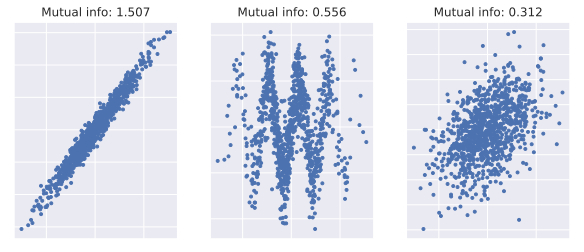

In [27]:
# Show mutual information plots
x = 5*np.random.randn(1000)
y = [x + np.random.randn(1000),
     2*np.sin(x) + np.random.randn(1000),
     x + 10*np.random.randn(1000)]
plt.figure(figsize=(10, 4))
for i in range(3):    
    plt.subplot(1, 3, i+1)
    plt.plot(x, y[i], '.')
    plt.title('Mutual info: %0.3f' % q_mut_info(x, y[i]))
    plt.gca().tick_params(labelbottom=False, labelleft=False)

In [28]:
%pdb on

# Compute aggregations
# list of valid methods to use:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#id1

# Some ideas:
# nunique of cat cols
# categorical entropy of cat cols

# Time:
# 30s for nunique
# 0.5s for sum
# 190s for entropy D:

# Aggregations to perform for each column
# NOTE: to get total # purchases for a cust, count is done on purchase_date
binary_aggs = ['mean']
categorical_aggs = ['nunique', entropy]
continuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew']
aggs = {
    'authorized_flag':      binary_aggs,
    'city_id':              categorical_aggs,
    'category_1':           binary_aggs,
    'installments':         continuous_aggs,
    'category_3':           categorical_aggs,
    'merchant_category_id': categorical_aggs,
    'merchant_id':          categorical_aggs,
    'month_lag':            continuous_aggs,
    'purchase_amount':      continuous_aggs,
    'purchase_date':        ['count'],# mean_time_between],
    'category_2':           categorical_aggs,
    'state_id':             categorical_aggs,
    'subsector_id':         categorical_aggs,
    'merchant_group_id':    categorical_aggs,
    'numerical_1':          continuous_aggs,
    'numerical_2':          continuous_aggs,
    'most_recent_sales_range':     categorical_aggs, #tho really might be continuous?
    'most_recent_purchases_range': categorical_aggs, #tho really might be continuous?
    'avg_sales_lag3':       continuous_aggs,
    'avg_purchases_lag3':   continuous_aggs,
    'active_months_lag3':   continuous_aggs,
    'avg_sales_lag6':       continuous_aggs,
    'avg_purchases_lag6':   continuous_aggs,
    'active_months_lag6':   continuous_aggs,
    'avg_sales_lag12':      continuous_aggs,
    'avg_purchases_lag12':  continuous_aggs,
    'active_months_lag12':  continuous_aggs,
    'category_4':           binary_aggs,
}

# Perform each aggregation and compute MI between the agg and target
mis = []
for col, funcs in aggs.items():
    for func in funcs:
        
        # Get name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__
            
        # Compute the mutual information
        train_cards['t_agg'] = trans[col].agg(func)
        mi = q_mut_info(train_cards['target'].values, 
                        train_cards['t_agg'].values)
        mis.append([col, func_str, mi])
        
print(pd.DataFrame(mis, columns=['Column', 'Function', 'MutInfo'])
      .sort_values('MutInfo', ascending=False).to_string())

Automatic pdb calling has been turned ON
                          Column Function   MutInfo
17                     month_lag      max  0.034595
14                   merchant_id  nunique  0.024549
12          merchant_category_id  nunique  0.023611
35             merchant_group_id  nunique  0.022850
103          active_months_lag12      sum  0.021887
28                 purchase_date    count  0.021854
85            active_months_lag6      sum  0.021852
67            active_months_lag3      sum  0.021849
55                avg_sales_lag3      sum  0.021849
61            avg_purchases_lag3      sum  0.021732
73                avg_sales_lag6      sum  0.021529
79            avg_purchases_lag6      sum  0.021476
91               avg_sales_lag12      sum  0.021260
97           avg_purchases_lag12      sum  0.021099
33                  subsector_id  nunique  0.020509
15                   merchant_id  entropy  0.018691
24               purchase_amount      sum  0.018411
36             merchant

Compute and store the best aggregations in the cards dataset.

In [29]:
# TODO: do that and save to csv

# TODO: though note you perhaps don't need the sum aggs for a lot of those cols
# as they are just acting as proxies to count of purchases